In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Get the first row to visualize the columns
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1bc57686f98>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23')

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
starting_date = most_recent_date.replace(day= most_recent_date.day - 1, year = most_recent_date.year - 1)
print(most_recent_date)
print(starting_date)

2017-08-23 00:00:00
2016-08-22 00:00:00


In [12]:
# Perform a query to retrieve the data and precipitation scores
query_results = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date > starting_date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.read_sql_query(query_results, session.bind)
results_df.set_index('date', inplace=True)

# Sort the dataframe by date
results_df.sort_index(inplace=True)
results_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [13]:
results_df.max()

prcp    6.7
dtype: float64

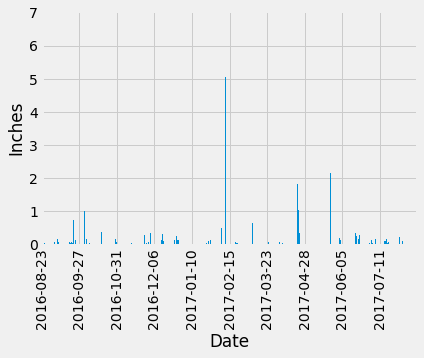

In [41]:
# Use Pandas Plotting with Matplotlib to plot the data
#fig = plt.figure(figsize=(10,5))
#ax = fig.add_subplot(111)

#results_df.iloc[::223].plot(kind='bar', ax=ax, position=1)

results_df['prcp'].plot.bar()
plt.ylabel('Inches')
plt.xlabel('Date')
ticks_labels = [res for res in results_df.index[::223]]
ticks = np.arange(0, len(results_df.index), 223)
plt.xticks(ticks,ticks_labels)
plt.show()

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [43]:
# Get the first row to visualize the columns
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1bc5eb8a6a0>,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1,
 'station': 'USC00519397',
 'longitude': -157.8168}

In [44]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(f'Total number of stations is: {total_stations}')

Total number of stations is: 9


In [45]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [46]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]

most_active_results = session.query(Measurement.station, Measurement.tobs).\
            filter(Measurement.station == most_active)
df = pd.read_sql_query(most_active_results.statement, session.bind)

df.describe()

,tobs
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Using: func.min, func.max, func.avg, func. count
min_active = session.query(func.min(Measurement.tobs)).\
            filter(Measurement.station == most_active).scalar()
max_active = session.query(func.max(Measurement.tobs)).\
            filter(Measurement.station == most_active).scalar()
avg_active = session.query(func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active).scalar()
count_active = session.query(func.count(Measurement.tobs)).\
            filter(Measurement.station == most_active).scalar()


print(f'Information for the most active station: {most_active}')
print(f'The minimum temperature is: {min_active}')      
print(f'The maximum temperature is: {max_active}') 
print(f'The average temperature is: {round(avg_active,2)}')
print(f'The total count of {most_active} is: {count_active}')

Information for the most active station: USC00519281
The minimum temperature is: 54.0
The maximum temperature is: 85.0
The average temperature is: 71.66
The total count of USC00519281 is: 2772


In [48]:
# Using the most active station id
# Verify the start date and the lates date of the most active station
min_date = session.query(func.min(Measurement.date)).\
            filter(Measurement.station == most_active).first()
max_date = session.query(func.max(Measurement.date)).\
            filter(Measurement.station == most_active).first()

print(f'Start date: {min_date[0]}')
print(f'Latest date: {max_date[0]}')


Start date: 2010-01-01
Latest date: 2017-08-18


In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date = dt.datetime.strptime(max_date[0], '%Y-%m-%d')
start_date = latest_date.replace(day = latest_date.day -1, year = latest_date.year -1)

query_results = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.date > start_date).all()

dates = [result[0] for result in query_results]
temps = [float(result[1]) for result in query_results]


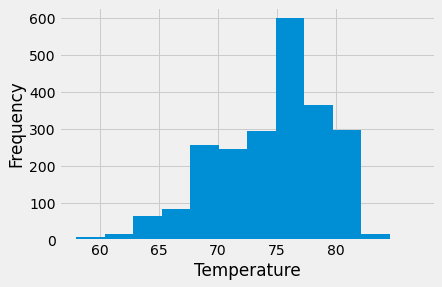

In [50]:
# Plot
plt.hist(temps, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.xticks([60,65,70,75,80])
plt.show()


# Close session

In [51]:
# Close Session
session.close()